# Spectral Parameterization - Hill et al., 2020

### imports & load data

In [1]:
import os

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import mne
#import neurodsp
import fooof
from fooof import FOOOFGroup
from fooof import FOOOF
from fooof.bands import Bands
from fooof.objs.utils import average_fg
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum
# Import functions to examine frequency-by-frequency error of model fits
from fooof.analysis.error import compute_pointwise_error_fm, compute_pointwise_error_fg

In [2]:
%matplotlib inline

### Functions

In [3]:
# Defining a function to get the cannonical power in a frequency band
def get_band_pow(freqs, spectra, band):
    """get average power in frequency band in spectrum
    Parameters
    ----------
    freqs : 1d array
        Frequency values
    spectra : 1d array
        Power spectrum power values
    band : list of [float, float]
        Band definition
    Returns
    -------
    band_pow : float
        average power in band
    """
    trim_freqs, trim_pows = trim_spectrum(freqs, spectra, f_range=band)
    band_pow = np.mean(trim_pows, axis=1)
    return band_pow

### Single subject ECT specparam demo

In [4]:
# pre_path = '../ECT004_PRE_EC_clean.set'
# post_path = '../ECT004_POST_EC_clean.set'

pre_path = '/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_PRE_REST_EC.fif'
post_path = '/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_POST_REST_EC.fif'

In [5]:
eeg_pre = mne.io.read_raw_fif(pre_path);
eeg_post = mne.io.read_raw_fif(post_path);

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3325033656.py:1: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_pre = mne.io.read_raw_fif(pre_path);


    Range : 0 ... 616999 =      0.000 ...   616.999 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3325033656.py:2: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_post = mne.io.read_raw_fif(post_path);


    Range : 0 ... 603919 =      0.000 ...   603.919 secs
Ready.


In [6]:
channels = eeg_pre.info['ch_names']

### plot power spectra

Effective window size : 2.048 (s)


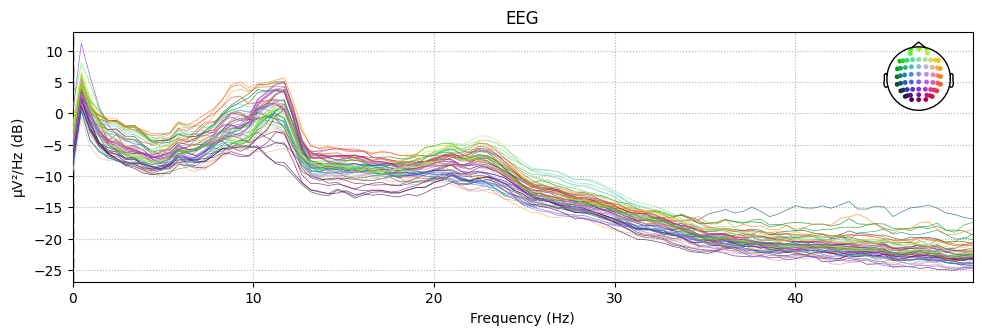

In [7]:
eeg_pre.plot_psd(fmax=50);

Effective window size : 2.048 (s)


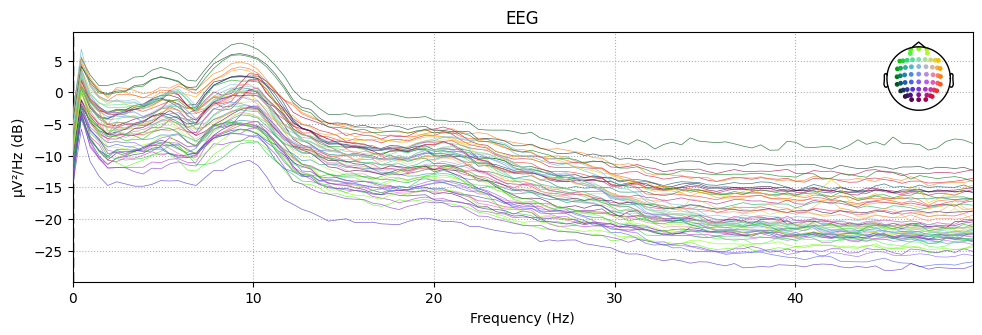

In [8]:
eeg_post.plot_psd(fmax=50);

### compute PSDs

In [9]:
psds, freqs = mne.time_frequency.psd_welch(eeg_pre, fmin=0, fmax=100, tmin=None, tmax=None, 
                                           n_fft=4000, n_overlap=2000, n_per_seg=None, picks=None, proj=False, 
                                           n_jobs=1, reject_by_annotation=True, average='mean', window='hamming', 
                                           verbose=None)
psds_post, freqs_post = mne.time_frequency.psd_welch(eeg_post, fmin=0, fmax=100, tmin=None, tmax=None, 
                                                     n_fft=4000, n_overlap=2000, n_per_seg=None, picks=None, 
                                                     proj=False, n_jobs=1, reject_by_annotation=True, 
                                                     average='mean', window='hamming', verbose=None)

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


### SpecParam Group results

In [31]:
fg_pre = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
fg_post = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)

fg_pre.fit(freqs, psds, freq_range = [0.5,30])
fg_post.fit(freqs_post, psds_post, freq_range=[0.5,30])

Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


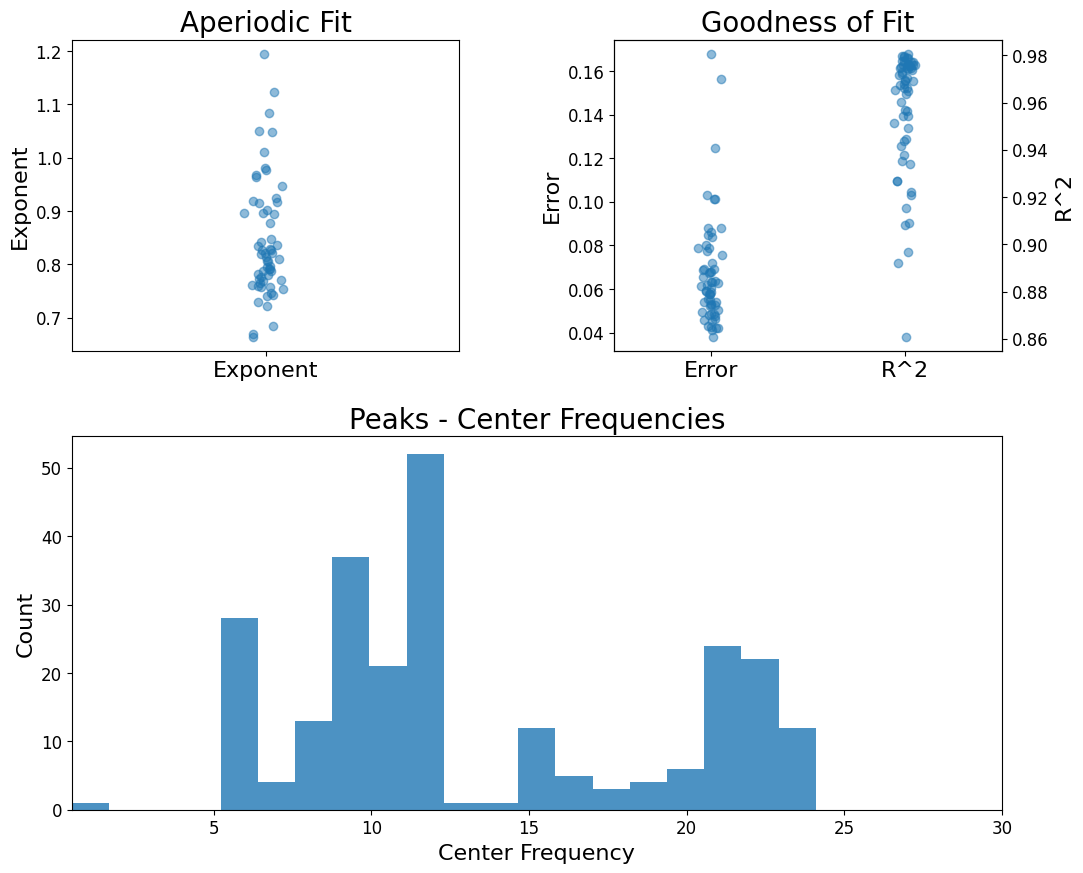

In [32]:
fg_pre.plot()

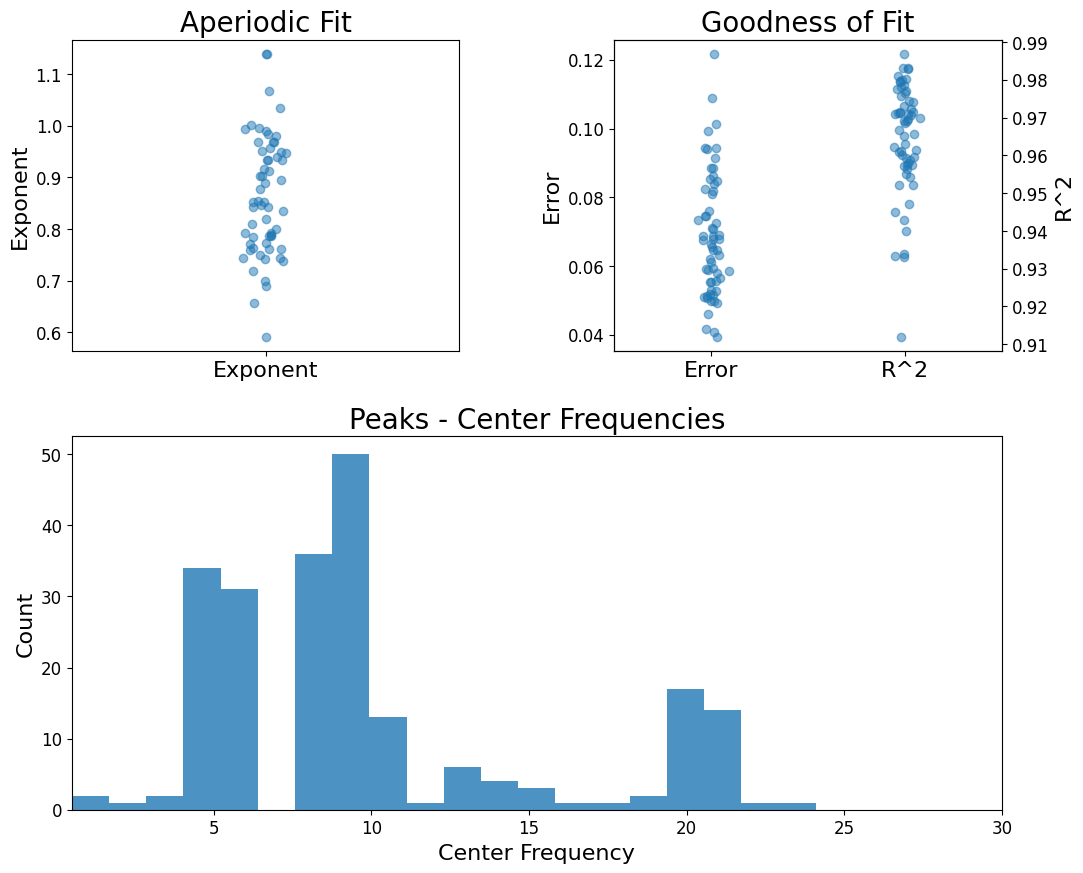

In [33]:
fg_post.plot()

### Specparam results

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 30 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -12.0257, 0.8390                                         
                                                                                                  
                                       3 peaks were found:                                        
          

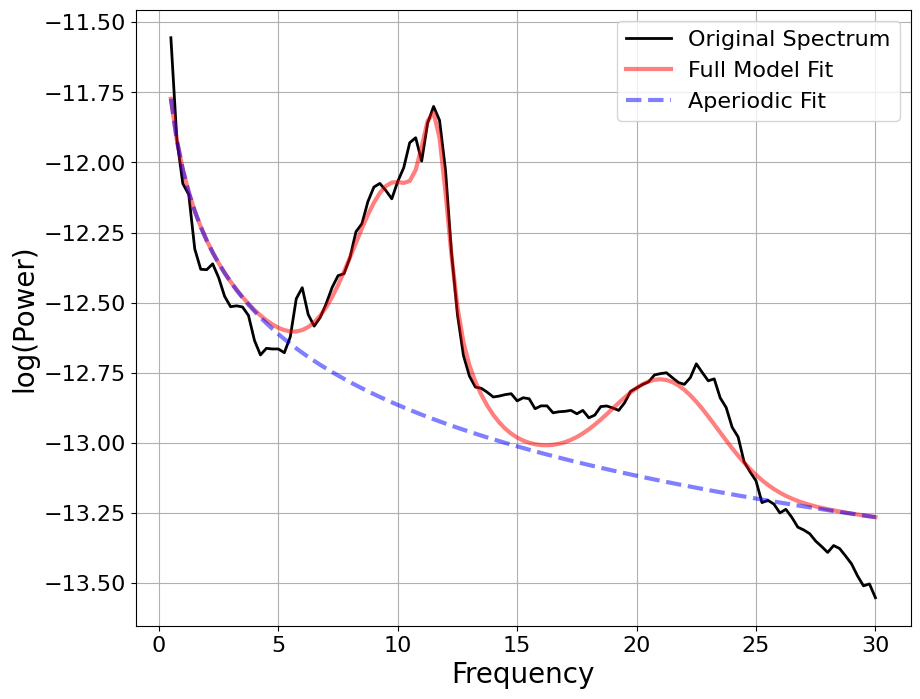

In [34]:
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.2, 
           aperiodic_mode = "fixed")
freq_range = [0.5, 30]
fm.report(freqs, psds.mean(axis=0), freq_range)

## 3. Full ECT dataset results

In [36]:
big_dat_path = '/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/'

len_channels_pre = []
all_channels_pre = []

len_channels_post = []
all_channels_post = []

all_patients = ['009', '010', '018', '022', '025', '033', '035', '040', 
                '046', '047', '053', '066', '069', '095', '117', '119', '125', '126', '130',
                '134', '144', '160', '191']
n_patients = len(all_patients)

post_psd = np.zeros((n_patients, 60, 401)) # changed in v2 from 60, 201
pre_psd = np.zeros((n_patients, 60, 401)) # changed in v2 from 60, 201


for count, patient in enumerate(all_patients):
    
    # create string that is the complete file name
#     ECT002_POST_EC_clean.set <-- example of file name
    file_name_post = 'MST' + patient + "_POST_REST_EC.fif"
    file_name_pre = 'MST' + patient + "_PRE_REST_EC.fif"


    # eeg data should look like [epochs, channels, timepoints]
    eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)  
    eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)
    
    # only pick eeg channels
    eeg_data_post.pick_types(eeg=True)
    eeg_data_pre.pick_types(eeg=True)
    
    # save channel name 
    len_channels_pre.append(len(eeg_data_pre.info['ch_names'])) # sanity check if there are 60 channels
    all_channels_pre.append(eeg_data_pre.info['ch_names'])
    
    len_channels_post.append(len(eeg_data_post.info['ch_names'])) # sanity check if there are 60 channels
    all_channels_post.append(eeg_data_post.info['ch_names'])
    
    # create psd's. psds.shape --> [60 channels, 201 frequencies] # changed in v2 from n_fft=2000 and n_overlap=1000
    psds_post, freqs_post = mne.time_frequency.psd_welch(eeg_data_post, fmin=0, fmax=100, tmin=None, tmax=None, n_fft=4000,
                                 n_overlap=2000, n_per_seg=None, picks=None, proj=False, n_jobs=1,
                                 reject_by_annotation=True, average='mean', window='hamming', verbose=None)
    psds_pre, freqs_pre = mne.time_frequency.psd_welch(eeg_data_pre, fmin=0, fmax=100, tmin=None, tmax=None, n_fft=4000,
                                 n_overlap=2000, n_per_seg=None, picks=None, proj=False, n_jobs=1,
                                 reject_by_annotation=True, average='mean', window='hamming', verbose=None)


    # Saving the psd's in a single data-structure
    post_psd[count, :, :] = psds_post#.mean(axis=0)  # post_psd shape --> [patients, 60 channels, 201 frequencies]
    pre_psd[count, :, :] = psds_pre#.mean(axis=0)  # pre_psd shape --> [patients, 60 channels, 201 frequencies]

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST009_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST009_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 777559 =      0.000 ...   777.559 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST009_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST009_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 648559 =      0.000 ...   648.559 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST010_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST010_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 620079 =      0.000 ...   620.079 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST010_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST010_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 623879 =      0.000 ...   623.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST018_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST018_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 604679 =      0.000 ...   604.679 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST018_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST018_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 684479 =      0.000 ...   684.479 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST022_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST022_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 644199 =      0.000 ...   644.199 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST022_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST022_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 622879 =      0.000 ...   622.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST025_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST025_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 628279 =      0.000 ...   628.279 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST025_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST025_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 366439 =      0.000 ...   366.439 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST033_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST033_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 725319 =      0.000 ...   725.319 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST033_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST033_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 612479 =      0.000 ...   612.479 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST035_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST035_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 633359 =      0.000 ...   633.359 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST035_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST035_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 621999 =      0.000 ...   621.999 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST040_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST040_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 620359 =      0.000 ...   620.359 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST040_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST040_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 688519 =      0.000 ...   688.519 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST046_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST046_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 610439 =      0.000 ...   610.439 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST046_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST046_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 615119 =      0.000 ...   615.119 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST047_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST047_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601119 =      0.000 ...   601.119 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST047_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST047_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 601919 =      0.000 ...   601.919 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST053_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST053_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 605119 =      0.000 ...   605.119 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST053_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST053_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 604359 =      0.000 ...   604.359 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST066_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST066_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 603079 =      0.000 ...   603.079 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST066_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST066_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 633759 =      0.000 ...   633.759 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST069_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST069_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 682959 =      0.000 ...   682.959 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST069_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST069_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 606039 =      0.000 ...   606.039 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST095_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST095_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 608719 =      0.000 ...   608.719 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST095_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST095_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 608519 =      0.000 ...   608.519 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST117_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST117_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 607439 =      0.000 ...   607.439 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST117_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST117_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 788999 =      0.000 ...   788.999 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST119_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST119_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 641439 =      0.000 ...   641.439 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST119_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST119_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 600719 =      0.000 ...   600.719 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST125_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST125_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 604479 =      0.000 ...   604.479 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST125_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST125_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 638879 =      0.000 ...   638.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 603919 =      0.000 ...   603.919 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST126_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 616999 =      0.000 ...   616.999 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST130_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST130_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 608639 =      0.000 ...   608.639 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST130_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST130_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 617279 =      0.000 ...   617.279 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST134_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST134_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601079 =      0.000 ...   601.079 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST134_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST134_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 663839 =      0.000 ...   663.839 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST144_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST144_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 621799 =      0.000 ...   621.799 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST144_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST144_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 602879 =      0.000 ...   602.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST160_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST160_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 765239 =      0.000 ...   765.239 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST160_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST160_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 727079 =      0.000 ...   727.079 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST191_POST_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:27: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST191_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 619319 =      0.000 ...   619.319 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST191_PRE_REST_EC.fif...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_38442/3879934681.py:28: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_MST_unfilt/MST191_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 604159 =      0.000 ...   604.159 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


In [37]:
# save pre and post_psd's as numpy
np.save('../saved_files_appeal/mst_files/pre_mst_psd.npy', pre_psd)
np.save('../saved_files_appeal/mst_files/post_mst_psd.npy', post_psd)
np.save('../saved_files_appeal/mst_files/mst_freq_axis.npy', freqs_pre)

In [38]:
# check if the channels are all the same for each patient
# dubble checked and it's all the same :D

channel_match_pre = []
for count, ind in enumerate(all_channels_pre):
    channel_match_pre.append(np.sum(all_channels_pre[0] == all_channels_pre[count]))
# check if the channels are all the same for each patient
channel_match_post = []
for count, ind in enumerate(all_channels_post):
    channel_match_post.append(np.sum(all_channels_post[0] == all_channels_post[count]))

In [39]:
print(channel_match_pre)
print(channel_match_post)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Loop da loop for fooof

In [4]:
# load in data
pre_psd = np.load('../saved_files_appeal/mst_files/pre_mst_psd.npy')
post_psd = np.load('../saved_files_appeal/mst_files/post_mst_psd.npy')
freqs = np.load('../saved_files_appeal/mst_files/mst_freq_axis.npy')

In [5]:
# Fooof settings
specparam_settings = {'peak_width_limits':[1, 8],
                     'min_peak_height':0.05,
                     'max_n_peaks':12,
                     'aperiodic_mode':'fixed'}
freq_range = [0.5,30] # changed in v2 from [1,30]

# define frequency bands
DELTA = [1,4]
THETA = [4,7]
ALPHA = [7,12]

fg_pre = FOOOFGroup(**specparam_settings)
fg_post = FOOOFGroup(**specparam_settings)

In [6]:
all_patients = ['009', '010', '018', '022', '025', '033', '035', '040', 
                '046', '047', '053', '066', '069', '095', '117', '119', '125', '126', '130',
                '134', '144', '160', '191']
n_patients = len(all_patients)

In [7]:
# tile patient and channel lists (to go into dictionaries)

# shapes should all be (1380,)
channels = np.tile(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2',
 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7',
 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2',
 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5',
 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2'], n_patients)  # repeating this list for pre/post dictionaries
patient_list = np.repeat(all_patients, 60) # 60 because len of channels, repeating this list for pre/post dictionaries

pre_list = np.tile('pre', 60*n_patients) # list of (1380,) pre's to add to dictionary
post_list = np.tile('post', 60*n_patients) # list of (1380,) post's to add to dictionary

In [8]:
delta_pre_amp = [] # Peak amplitude above aperiodic signal
delta_pre_cf = [] # Center frequency
delta_pre_bw = [] # Bandwidth
delta_pre_bp = [] # Canonnical band power

delta_post_amp = []
delta_post_cf = []
delta_post_bw = []
delta_post_bp = []

theta_pre_amp = []
theta_pre_cf = []
theta_pre_bw = []
theta_pre_bp = []

theta_post_amp = []
theta_post_cf = []
theta_post_bw = []
theta_post_bp = []

alpha_pre_amp = []
alpha_pre_cf = []
alpha_pre_bw = []
alpha_pre_bp = []

alpha_post_amp = []
alpha_post_cf = []
alpha_post_bw = []
alpha_post_bp = []

fits_pre = np.zeros((n_patients, 60, 119)) # changed in v2 from 60, 59
fits_post = np.zeros((n_patients, 60, 119)) # changed in v2 from 60, 59

offset_pre = []
knee_pre = []
exponent_pre = []

offset_post = []
knee_post = []
exponent_post = []

error_pre = []
r_squared_pre = []

error_post = []
r_squared_post = []

for count, patient in enumerate(all_patients):

#     [patients, 60 channels, 201 frequencies]
    fg_pre.fit(freqs, pre_psd[count,:,:], freq_range = freq_range, n_jobs=-1)
    fg_post.fit(freqs, post_psd[count,:,:], freq_range = freq_range,  n_jobs=-1)
    
    periodic_delta_pre = get_band_peak_fg(fg_pre, DELTA)  # periodic params (amp, cf, bandwidth)
    periodic_theta_pre = get_band_peak_fg(fg_pre, THETA)  # periodic params (amp, cf, bandwidth)
    periodic_alpha_pre = get_band_peak_fg(fg_pre, ALPHA)  # periodic params (amp, cf, bandwidth)
    
    periodic_delta_post = get_band_peak_fg(fg_post, DELTA)  # periodic params (amp, cf, bandwidth)
    periodic_theta_post = get_band_peak_fg(fg_post, THETA)  # periodic params (amp, cf, bandwidth)
    periodic_alpha_post = get_band_peak_fg(fg_post, ALPHA)  # periodic params (amp, cf, bandwidth)
    
    aperiodic_pre = fg_pre.get_params('aperiodic_params')  # get the aperiodic 1/f properties (offset, knee, exp)
    aperiodic_post = fg_post.get_params('aperiodic_params')  # get the aperiodic 1/f properties (offset, knee, exp)

    all_errors_pre = fg_pre.get_params('error')
    all_errors_post = fg_post.get_params('error')
    
    all_r_squared_pre = fg_pre.get_params('r_squared')
    all_r_squared_post = fg_post.get_params('r_squared')    
    
    
    
    # Each variable as a list, store for each patient
    delta_pre_cf = np.concatenate([delta_pre_cf, periodic_delta_pre[:,0]])
    delta_pre_amp = np.concatenate([delta_pre_amp, periodic_delta_pre[:,1]])
    delta_pre_bw = np.concatenate([delta_pre_bw, periodic_delta_pre[:,2]])
    delta_pre_bp = np.concatenate([delta_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], DELTA))])
    
    delta_post_cf = np.concatenate([delta_post_cf, periodic_delta_post[:,0]])
    delta_post_amp = np.concatenate([delta_post_amp, periodic_delta_post[:,1]])
    delta_post_bw = np.concatenate([delta_post_bw, periodic_delta_post[:,2]])
    delta_post_bp = np.concatenate([delta_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], DELTA))])
    
    theta_pre_cf = np.concatenate([theta_pre_cf, periodic_theta_pre[:,0]])
    theta_pre_amp = np.concatenate([theta_pre_amp, periodic_theta_pre[:,1]])
    theta_pre_bw = np.concatenate([theta_pre_bw, periodic_theta_pre[:,2]])
    theta_pre_bp = np.concatenate([theta_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], THETA))])
    
    theta_post_cf = np.concatenate([theta_post_cf, periodic_theta_post[:,0]])
    theta_post_amp = np.concatenate([theta_post_amp, periodic_theta_post[:,1]])
    theta_post_bw = np.concatenate([theta_post_bw, periodic_theta_post[:,2]])
    theta_post_bp = np.concatenate([theta_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], THETA))])
    
    alpha_pre_cf = np.concatenate([alpha_pre_cf, periodic_alpha_pre[:,0]])
    alpha_pre_amp = np.concatenate([alpha_pre_amp, periodic_alpha_pre[:,1]])
    alpha_pre_bw = np.concatenate([alpha_pre_bw, periodic_alpha_pre[:,2]])
    alpha_pre_bp = np.concatenate([alpha_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], ALPHA))])
    
    alpha_post_cf = np.concatenate([alpha_post_cf, periodic_alpha_post[:,0]])
    alpha_post_amp = np.concatenate([alpha_post_amp, periodic_alpha_post[:,1]])
    alpha_post_bw = np.concatenate([alpha_post_bw, periodic_alpha_post[:,2]])
    alpha_post_bp = np.concatenate([alpha_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], ALPHA))])
    
    offset_pre = np.concatenate([offset_pre, aperiodic_pre[:,0]])
    #knee_pre = np.concatenate([knee_pre, aperiodic_pre[:,1]])
    exponent_pre = np.concatenate([exponent_pre, aperiodic_pre[:,1]])
    
    offset_post = np.concatenate([offset_post, aperiodic_post[:,0]])
    #knee_post = np.concatenate([knee_post, aperiodic_post[:,1]])
    exponent_post = np.concatenate([exponent_post, aperiodic_post[:,1]])
    
    error_pre = np.concatenate([error_pre, all_errors_pre])
    error_post = np.concatenate([error_post, all_errors_post])

    r_squared_pre = np.concatenate([r_squared_pre, all_r_squared_pre])
    r_squared_post = np.concatenate([r_squared_post, all_r_squared_post])
    
    for channel in np.arange(0,60):
        fits_pre[count, channel, :] = fg_pre.get_fooof(channel).fooofed_spectrum_
        fits_post[count, channel, :] = fg_post.get_fooof(channel).fooofed_spectrum_


Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 pow

# Save specparam output into a dataframe

### Delete bad fits from fooof fits

In [9]:
# Add column to df for exclusions
# Excluding all with low r_squared

pre_exclude = r_squared_pre < 0.8
post_exclude = r_squared_post < 0.8

In [10]:
exclude_list = []

for row in np.arange(0, len(pre_exclude)):
    exclude_list.append(pre_exclude[row] or post_exclude[row])


In [11]:
# create dictionary
headers_list_pre = ['patient', 'pre_post', 'channel', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 
                    'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 
                    'alpha_bp','offset', 'exponent', 'error', 'r_squared', 'exclude']
headers_list_post = ['patient', 'pre_post', 'channel', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 
                    'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 
                    'alpha_bp','offset', 'exponent', 'error', 'r_squared', 'exclude']
variables_list_pre = [patient_list, pre_list, channels, delta_pre_cf, delta_pre_bw, delta_pre_amp, delta_pre_bp,
                     theta_pre_cf, theta_pre_bw, theta_pre_amp, theta_pre_bp, alpha_pre_cf, alpha_pre_bw, alpha_pre_amp,
                    alpha_pre_bp, offset_pre, exponent_pre, error_pre, r_squared_pre, exclude_list]
variables_list_post = [patient_list, post_list, channels, delta_post_cf, delta_post_bw, delta_post_amp, delta_post_bp,
                     theta_post_cf, theta_post_bw, theta_post_amp, theta_post_bp, alpha_post_cf, alpha_post_bw, 
                       alpha_post_amp, alpha_post_bp, offset_post, exponent_post, error_post, r_squared_post, exclude_list]

exp_pre_dict = dict(zip(headers_list_pre, variables_list_pre))
exp_post_dict = dict(zip(headers_list_post, variables_list_post))

In [12]:
# save dictionary as pandas
exp_pre_df = pd.DataFrame(exp_pre_dict)
exp_post_df = pd.DataFrame(exp_post_dict)

exp_df = pd.concat([exp_pre_df, exp_post_df], axis=0, ignore_index=True)

In [13]:
# exclude patient 40 for bad model fits (47/60)
exp_df.loc[exp_df.patient=='040', 'exclude'] = True

# save pandas df as csv
exp_df.to_csv('../saved_files_appeal/mst_files/mst_all_features.csv')

In [50]:
# Save fooofed spectra
np.save('../saved_files_appeal/mst_files/mst_fits_pre.npy', fits_pre)
np.save('../saved_files_appeal/mst_files/mst_fits_post.npy', fits_post)